In [1]:
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn

import random
import string
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
%matplotlib inline

You should consider upgrading via the '/home/liza/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/liza/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/liza/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/liza/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/liza/anaconda3/bin/python -m pip install --upgrade pip' command.


In [371]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [372]:
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, random_state=18, test_size=0.2, shuffle=True)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 120 Test size: 30


In [373]:
def labels_to_onehot(labels):
    """
        Convert the indices to one-hot representation
        labels: np.array of labels, shape=(N,)

        return np.array, shape=(N, k)
       """
    
    n_classes = len(set(labels))
    n_samples = len(labels)

    # create a matrix of zeros of shape (n_samples, n_classes)
    one_hot = np.zeros((n_samples, n_classes))

    # fill one-hot values
    for index in range(len(labels)):
        one_hot[index][labels[index]] = 1

    return one_hot

In [374]:
y_train_ohe = labels_to_onehot(Y_train)
np.shape(y_train_ohe)

(120, 3)

## 3

In [375]:
# 5 features x 3 classes
W_toy = np.array([[0.2, -0.3, 0.5],
                 [-0.9, 0.6, 0.4],
                 [0.1, 0.7, -0.2],
                 [0.6, 0.1, -0.3],
                 [0.7, -0.1, 0.6]])

# 3 classes
b_toy = np.array([[0.05, 0.1, -0.2]])

# 4 examples x 5 features
x_toy = np.array([[-1.0, -0.7, 0.3, 0.8, 0],
                 [0.5, -0.2, 0.6, 0, -0.4],
                 [0.1, 0, -0.4, -0.1, -0.2],
                 [0.6, 0.7, 0.2, 0.1, 0.4]])

# 3 classes one-hot
y_true_toy = np.array([[0, 1, 0],
                      [1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])

### 3.1

In [376]:
def linear(x, W, b):
    """
        Compute output of linear transformation given x, W, b
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases

        return np.array, shape=[m, k]
    """
    
    z = (W.T @ x.T + b.T).T
    return z

In [377]:
z_toy = linear(x_toy, W_toy, b_toy)
print('Z:\n', z_toy)

Z:
 [[ 0.99  0.27 -1.28]
 [ 0.11  0.29 -0.39]
 [-0.17 -0.2  -0.16]
 [-0.1   0.45  0.55]]


### 3.2

In [378]:
def softmax(z):
    """
        Compute softmax values for each element (or score) in z
        z: np.array, shape=[m, k]

        return np.array, shape=[m, k]
    """
    soft = np.exp(z)/(np.tile(np.sum(np.exp(z), axis=1), z.shape[1]).reshape(z.shape[::-1])).T
    return soft

In [379]:
%%time
y_toy = softmax(z_toy)
print('y:\n', y_toy)
print('y sum by columns:\n', np.sum(y_toy, axis=1))

y:
 [[0.62890533 0.30612109 0.06497358]
 [0.35666543 0.42700605 0.21632852]
 [0.33551466 0.3255987  0.33888664]
 [0.21510956 0.37283929 0.41205115]]
y sum by columns:
 [1. 1. 1. 1.]
CPU times: user 1.28 ms, sys: 124 µs, total: 1.41 ms
Wall time: 1.25 ms


### 3.3

In [380]:
def cross_entropy(y, y_true, epsilon=1e-9):
    """
        Compute the cross entropy loss function for model softmax output with respect to labels.

        y: np.array, shape=[m, k] output predictions of softmax
        y_true: np.array, shape=[m, k] one-hot encoded true labels
        epsilon: float, small constant to add to input of log for computational stability

        return: np.float, the value of the loss function
    """
    loss = - np.sum(y_true * np.log(y + epsilon))/y.shape[0]

    return loss

### 3.4

In [381]:
def regularization(params, lam=0.05):
    
    """
        Compute gradients for squared weight regularization. A list of parameters
        should be provided to this function (for example, [weight, bias] for a linear network). Loss value and gradients are calculated together for simplicity.

        params: list of np.arrays, each a parameter (matrix or vector) of the model to be regularized
        lam: float, lambda coefficient multiplied by regularization term

        Return: float value of regularization loss, list of np.array gradients, one per each param
    """

    gradients = []
    value = 0
    params = np.array(params)
    
    for param in params:
        gradients.append(2*lam*param)
        value += lam * (np.linalg.norm(param)**2)
    
    return value, gradients

In [382]:
xent_toy = cross_entropy(y_toy, y_true_toy)
print('Cross entropy:', xent_toy)
value, _ = regularization([W_toy, b_toy])
print('L2 regularization: %s' % value)

Cross entropy: 1.0558572646711712
L2 regularization: 0.18112499999999998


### 3.5

In [383]:
def softmax_cross_entropy_backward(z, y_true):
    """
        Compute gradients of loss with respect to linear outputs z and true labels (y_true).
        This is the gradients produced by the softmax and cross entropy functions combined.

        z: np.array, shape=[m, k]
        y_true: np.array, shape=[m, k] one-hot encoded labels

        return: gradient of loss with respect to z
    """
    y = softmax(z)
    dldz = y_true - y
        
    return -dldz/z.shape[0]

print(softmax_cross_entropy_backward(z_toy, y_true_toy))

[[ 0.15722633 -0.17346973  0.0162434 ]
 [-0.16083364  0.10675151  0.05408213]
 [ 0.08387866 -0.16860032  0.08472166]
 [ 0.05377739  0.09320982 -0.14698721]]


### 3.6

In [384]:
def linear_backward(x, W, z_grad):
    """
        Compute gradients for loss function with respect to inputs x, W, and b given z_grad (dL/dz).

        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        z_grad: np.array, shape=[m, k] gradient of loss with respect to output z

        return: dL/dx: np.array, shape=[m, d],
  ### 3.1              dL/dW: np.array, shape=[d, k],
                dL/db: np.array, shape=[1, k]
    """
    dldx = z_grad@W.T
    dldw = x.T@z_grad
    dldb = np.sum(z_grad, axis=0)
    
    return dldx, dldw, dldb

z_grad = softmax_cross_entropy_backward(z_toy, y_true_toy)
linear_backward(x_toy, W_toy, z_grad)

(array([[ 0.09160788, -0.23908818, -0.10895486,  0.07211581,  0.13715144],
        [-0.03715112,  0.23043404,  0.04782627, -0.10204967, -0.09080942],
        [ 0.10971666, -0.14276233, -0.12657669,  0.00805067,  0.12640809],
        [-0.09070108, -0.05126864,  0.10002206,  0.08568358, -0.05986914]]),
 array([[-0.19698885,  0.26591135, -0.06892249],
        [-0.04024753,  0.16532538, -0.12507785],
        [-0.07212827,  0.09809208, -0.02596381],
        [ 0.12277094, -0.11259477, -0.01017617],
        [ 0.06906868,  0.02830339, -0.09737207]]),
 array([ 0.13404875, -0.14210872,  0.00805997]))

### 3.7

In [385]:
def init_params(x, y_true):
    """Given x and y pairs from the dataset, initialize parameters for the linear network.
    
    x: np.array, shape=[m, d]
    y_true: np.array, shape=[m, k]
    
    Return: list of np.array parameters"""
    n_features = x.shape[1]
    n_classes = y_true.shape[1]

    W = np.random.normal(0, 1, n_features*n_classes).reshape((n_features, n_classes))
    b = np.zeros(n_classes).reshape((1, n_classes))
    
    return [W, b]

def update_weights(params, x, y_true, alpha, lam=0.05):
    """
        Update network weights as a step of gradient descent. This function should calculate gradients with respect
        to the cross entropy loss, as well as the L2 weight regularization, then apply these gradients to the model
        parameters.
        
        params: list of parameters to update
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases
        y_true: np.array, shape=[m, k] one-hot encoded labels
        alpha: float, learning rate
        lam: lambda regularization constant
        record_values: used to write values
        
        return: computed loss for model output (cross entropy + regularization losses)
    """
    W, b = params
    
    z = linear(x,W,b)
    y = softmax(z)
    
    _, dldw, dldb = linear_backward(x, W, softmax_cross_entropy_backward(z, y_true))
    reg_loss, gradients = regularization(params, lam)
    loss = cross_entropy(y,y_true)
    
    W -= alpha*(dldw + gradients[0])
    b -= alpha*(dldb + gradients[1])

    #print("loss = ", loss , reg_loss)
    return loss + reg_loss

In [386]:
loss = update_weights([W_toy, b_toy], x_toy, y_true_toy, 0.1)

In [387]:
print('Loss:', loss)

Loss: 1.2369822646711712


### 3.8

In [388]:
def train(init_func, update_func, x, y_true, batch_size=50, num_epoch=1, learning_rate=1e-3, lam=0.001, plot_loss=True):
    """
        Train a neural network.
        
        init_func: function mapping (x, y_true) --> params
        update_func: function mapping (list params, np.array x, np.array y_true, float alpha, float lam) --> float loss, while updating parameters
        x_train: np.array, shape=[m, d]
        y_train: np.array, shape=[m, k] one-hot encoding of labels
        batch_size: int, number of examples in a batch
        num_epoch: int, number of training iterations
        learning_rate: float, learning rate
        lam: float, regularization parameter
        plot_loss: bool, optionally plot the learning curve
        
        return: list of losses per batch over all epochs, learned list of parameters
    """
    
    losses = []
    batch_losses = []
    
    n_batches = x.shape[0] // batch_size
    params = init_func(x, y_true)

    for epoch in range(num_epoch):
        for iter_num, (x_batch, y_batch) in enumerate(zip(np.array_split(x, n_batches), np.array_split(y_true, n_batches))):
            batch_losses.append(update_func(params, x_batch, y_batch, learning_rate, lam))
            
        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)
        batch_losses = []
        print(f'Epoch: {epoch:<5} Loss: {epoch_loss:.3f}')
        
            
    # draw learning curve 
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        if 1:
            plt.xlabel("epochs")
        else:
            plt.xlabel("batches")
        plt.show()
        
    return losses, params

Epoch: 0     Loss: 1.612
Epoch: 1     Loss: 0.617
Epoch: 2     Loss: 0.378
Epoch: 3     Loss: 0.268
Epoch: 4     Loss: 0.213
Epoch: 5     Loss: 0.180
Epoch: 6     Loss: 0.159
Epoch: 7     Loss: 0.144
Epoch: 8     Loss: 0.134
Epoch: 9     Loss: 0.126


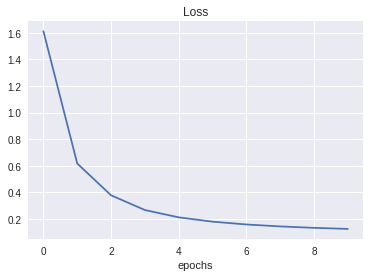

In [389]:
# DO NOT MODIFY THIS CELL
losses_toy, params = train(init_params, update_weights, x_toy, y_true_toy, batch_size=1, num_epoch=10, learning_rate=1)
W_learned, b_learned = params

### 3.9

Epoch: 0     Loss: 4.536
Epoch: 1     Loss: 2.456
Epoch: 2     Loss: 1.982
Epoch: 3     Loss: 1.606
Epoch: 4     Loss: 1.327
Epoch: 5     Loss: 1.139
Epoch: 6     Loss: 1.025
Epoch: 7     Loss: 0.943
Epoch: 8     Loss: 0.887
Epoch: 9     Loss: 0.840
Epoch: 10    Loss: 0.806
Epoch: 11    Loss: 0.774
Epoch: 12    Loss: 0.751
Epoch: 13    Loss: 0.726
Epoch: 14    Loss: 0.709
Epoch: 15    Loss: 0.687
Epoch: 16    Loss: 0.677
Epoch: 17    Loss: 0.654
Epoch: 18    Loss: 0.652
Epoch: 19    Loss: 0.623
Epoch: 20    Loss: 0.638
Epoch: 21    Loss: 0.595
Epoch: 22    Loss: 0.647
Epoch: 23    Loss: 0.577
Epoch: 24    Loss: 0.694
Epoch: 25    Loss: 0.570
Epoch: 26    Loss: 0.725
Epoch: 27    Loss: 0.556
Epoch: 28    Loss: 0.714
Epoch: 29    Loss: 0.542
Epoch: 30    Loss: 0.700
Epoch: 31    Loss: 0.528
Epoch: 32    Loss: 0.685
Epoch: 33    Loss: 0.515
Epoch: 34    Loss: 0.670
Epoch: 35    Loss: 0.503
Epoch: 36    Loss: 0.655
Epoch: 37    Loss: 0.491
Epoch: 38    Loss: 0.640
Epoch: 39    Loss: 0.479


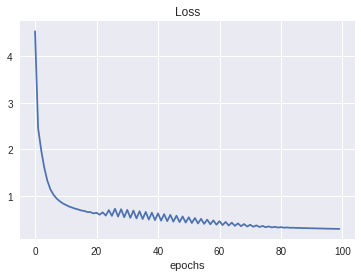

In [390]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, random_state=18, test_size=0.2, shuffle=True)

y_train_ohe = labels_to_onehot(Y_train)

losses, params = train(init_params, update_weights, X_train, y_train_ohe, batch_size=32, num_epoch=100, learning_rate=0.1, plot_loss=True)
W_learned, b_learned = params

### 3.10

In [391]:
with open("weight.txt",'w') as f:
    for i in range(W_learned.shape[0]):
        f.write(str(W_learned[i])+'  '+ str())

In [392]:
def make_prediction(x, W, b):
    """
        Make predictions for the given inputs x.

        x: np.array [N, d], inputs
        W: np.array, shape=[d, k], weights
        b: np.array, shape=[1, k], biases

        return: np.array of labels with shape [N]
    """
    prediction = np.argmax(softmax(linear(x,W,b)), axis=1)
    
    return prediction

In [393]:
y_pred = make_prediction(X_train, W_learned, b_learned)

In [394]:
y_pred

array([2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1,
       0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 0,
       1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 1, 2, 0,
       2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0,
       1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 1,
       2, 2, 1, 2, 0, 1, 1, 2, 0, 0])

In [395]:
accuracy = accuracy_score(Y_train, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9583333333333334


In [396]:
y_pred = make_prediction(X_test, W_learned, b_learned)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 1.0


## 4

### 4.1

In [397]:
def relu(z):
    """
        Compute relu activation as max(z, 0)
        
        z: np.array, shape=[m, d]

        Return: np.array, shape=[m, d]
    """
    _z = z.copy()
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            _z[i,j] = max(0, z[i,j])
    
    return _z

In [418]:
def relu_backward(z, a_grad):
    """
        Return gradient of loss with respect to input z given the output gradient.

        z: np.array, shape=[m, d] input to relu, not the output
        
        return: gradient dL/dz np.array, shape=[m, d]
    """
    dldz = a_grad * np.heaviside(z, 0) #aka max(a_grad,0)
    
    return dldz

### 4.2

In [419]:
def neural_network(x, W1, b1, W2, b2):
    """
        Use layers created above to define two-layer neural network with relu activation.

        x: np.array, shape=[m, n_features]
        W1: np.array, shape=[m, d2] first layer weights
        W2: np.array, shape=[d2, k] second layer weights
        b1: np.array, shape=[1, d2] first layer bias
        b2: np.array, shape=[1, k] second layer bias

        return: tuple, output of the linear layer, output of the relu, output of the final linear layer
    """

    z1 = linear(x,W1,b1)
    a1 = relu(z1)
    z2 = linear(a1,W2,b2)
    
    return (z1, a1, z2)

### 4.3

In [420]:
def neural_network_backward(x, W1, b1, W2, b2, z1, a1, z2, z2_grad):
    """
        Compute gradients of loss with respect to inputs x, W1, b1, W2, and b2.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        z1, z2, z3: np.array activations of linear, relu, and linear layers
        z3_grad: np.array, shape=[m, k] gradient of loss with respect to network output dL/dz3

        return: tuple: gradients dL/dW1, dL/db1, dL/dW2, dL/db2
    """
    
    a1_grad, W2_grad, b2_grad = linear_backward(a1, W2, z2_grad)
    z1_grad = relu_backward(z1, a1_grad)
    _, W1_grad, b1_grad = linear_backward(x, W1, z1_grad)
        
    return W1_grad, b1_grad, W2_grad, b2_grad

### 4.4

In [421]:
def init_neural_network_params(x, y_true):
    """
        Initialize weights and biases of two layer neural network, given input data.
        
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] true label one-hot
        
        return: list of np.array parameters
    """
    n_features = x.shape[1]
    n_classes = y_true.shape[1]
    n_middle = n_classes * 4  # we arbitrarily pick the middle layer size to be 4 times bigger than the output

    W1 = np.random.normal(0, 1, n_features*n_middle).reshape((n_features, n_middle))
    b1 = np.zeros(n_middle).reshape((1, n_middle))
    
    W2 = np.random.normal(0, 1, n_middle*n_classes).reshape((n_middle, n_classes))
    b2 = np.zeros(n_classes).reshape((1, n_classes))
    
    return [W1, W2, b1, b2]

def update_neural_network_weights(params, x, y_true, alpha, lam=0.001):
    """
        Given neural network parameters, update parameters and return loss.
        
        params: list of np.array parameters
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] output labels one-hot
        alpha: learning rate (float)
        lam: lambda regularization constant (float)
        
        return: float sum of cross entropy loss and L2 regularization losses
    """
    # place your code below
    
    W1, W2, b1, b2 = params
    (z1, a1, z2) = neural_network(x, W1, b1, W2, b2)
    y = softmax(z2)
    
    z2_grad = softmax_cross_entropy_backward(z2, y_true)
    W1_grad, b1_grad, W2_grad, b2_grad = neural_network_backward(x, W1, b1, W2, b2, z1, a1, z2, z2_grad)
    reg_loss, gradients = regularization(params, lam)
    
    loss = cross_entropy(y,y_true)
    
    # place your code above
    W1 -= alpha * (W1_grad + gradients[0])
    W2 -= alpha * (W2_grad + gradients[1])
    b1 -= alpha * (b1_grad + gradients[2])
    b2 -= alpha * (b2_grad + gradients[3])
    
    return loss  + reg_loss

### 4.5

In [430]:
def make_prediction_network(x, W1, b1, W2, b2):
    """
        Make predictions for the given inputs x.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        return: np.array of labels with shape [N]
    """
    z1 = linear(x,W1,b1)
    a1 = relu(z1)
    z2 = linear(a1,W2,b2)
    sm = softmax(z2)
    prediction = np.argmax(sm, axis=1)
    
    return prediction, sm

Epoch: 0     Loss: 0.790
Epoch: 1     Loss: 0.427
Epoch: 2     Loss: 0.319
Epoch: 3     Loss: 0.259
Epoch: 4     Loss: 0.227
Epoch: 5     Loss: 0.201
Epoch: 6     Loss: 0.187
Epoch: 7     Loss: 0.173
Epoch: 8     Loss: 0.165
Epoch: 9     Loss: 0.156
Epoch: 10    Loss: 0.151
Epoch: 11    Loss: 0.145
Epoch: 12    Loss: 0.141
Epoch: 13    Loss: 0.138
Epoch: 14    Loss: 0.134
Epoch: 15    Loss: 0.132
Epoch: 16    Loss: 0.129
Epoch: 17    Loss: 0.127
Epoch: 18    Loss: 0.125
Epoch: 19    Loss: 0.124
Epoch: 20    Loss: 0.122
Epoch: 21    Loss: 0.121
Epoch: 22    Loss: 0.120
Epoch: 23    Loss: 0.118
Epoch: 24    Loss: 0.117
Epoch: 25    Loss: 0.116
Epoch: 26    Loss: 0.116
Epoch: 27    Loss: 0.115
Epoch: 28    Loss: 0.114
Epoch: 29    Loss: 0.113
Epoch: 30    Loss: 0.113
Epoch: 31    Loss: 0.112
Epoch: 32    Loss: 0.111
Epoch: 33    Loss: 0.111
Epoch: 34    Loss: 0.110
Epoch: 35    Loss: 0.110
Epoch: 36    Loss: 0.109
Epoch: 37    Loss: 0.109
Epoch: 38    Loss: 0.108
Epoch: 39    Loss: 0.108


Epoch: 390   Loss: 0.071
Epoch: 391   Loss: 0.071
Epoch: 392   Loss: 0.071
Epoch: 393   Loss: 0.071
Epoch: 394   Loss: 0.071
Epoch: 395   Loss: 0.071
Epoch: 396   Loss: 0.071
Epoch: 397   Loss: 0.071
Epoch: 398   Loss: 0.071
Epoch: 399   Loss: 0.071
Epoch: 400   Loss: 0.071
Epoch: 401   Loss: 0.070
Epoch: 402   Loss: 0.070
Epoch: 403   Loss: 0.070
Epoch: 404   Loss: 0.070
Epoch: 405   Loss: 0.070
Epoch: 406   Loss: 0.070
Epoch: 407   Loss: 0.070
Epoch: 408   Loss: 0.070
Epoch: 409   Loss: 0.070
Epoch: 410   Loss: 0.070
Epoch: 411   Loss: 0.070
Epoch: 412   Loss: 0.070
Epoch: 413   Loss: 0.070
Epoch: 414   Loss: 0.070
Epoch: 415   Loss: 0.070
Epoch: 416   Loss: 0.070
Epoch: 417   Loss: 0.070
Epoch: 418   Loss: 0.070
Epoch: 419   Loss: 0.069
Epoch: 420   Loss: 0.069
Epoch: 421   Loss: 0.069
Epoch: 422   Loss: 0.069
Epoch: 423   Loss: 0.069
Epoch: 424   Loss: 0.069
Epoch: 425   Loss: 0.069
Epoch: 426   Loss: 0.069
Epoch: 427   Loss: 0.069
Epoch: 428   Loss: 0.069
Epoch: 429   Loss: 0.069


Epoch: 840   Loss: 0.053
Epoch: 841   Loss: 0.053
Epoch: 842   Loss: 0.053
Epoch: 843   Loss: 0.053
Epoch: 844   Loss: 0.053
Epoch: 845   Loss: 0.053
Epoch: 846   Loss: 0.052
Epoch: 847   Loss: 0.052
Epoch: 848   Loss: 0.052
Epoch: 849   Loss: 0.052
Epoch: 850   Loss: 0.052
Epoch: 851   Loss: 0.052
Epoch: 852   Loss: 0.052
Epoch: 853   Loss: 0.052
Epoch: 854   Loss: 0.052
Epoch: 855   Loss: 0.052
Epoch: 856   Loss: 0.052
Epoch: 857   Loss: 0.052
Epoch: 858   Loss: 0.052
Epoch: 859   Loss: 0.052
Epoch: 860   Loss: 0.052
Epoch: 861   Loss: 0.052
Epoch: 862   Loss: 0.052
Epoch: 863   Loss: 0.052
Epoch: 864   Loss: 0.052
Epoch: 865   Loss: 0.052
Epoch: 866   Loss: 0.052
Epoch: 867   Loss: 0.052
Epoch: 868   Loss: 0.052
Epoch: 869   Loss: 0.052
Epoch: 870   Loss: 0.052
Epoch: 871   Loss: 0.052
Epoch: 872   Loss: 0.052
Epoch: 873   Loss: 0.052
Epoch: 874   Loss: 0.052
Epoch: 875   Loss: 0.052
Epoch: 876   Loss: 0.052
Epoch: 877   Loss: 0.052
Epoch: 878   Loss: 0.052
Epoch: 879   Loss: 0.052


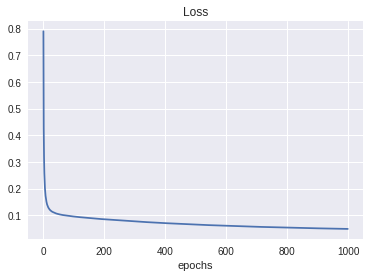

In [431]:
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights, x_toy, y_true_toy, batch_size=1, num_epoch=1000, learning_rate=0.1, plot_loss=True, lam=0.001)#, verbose=False)

### 4.6

Epoch: 0     Loss: 20.058
Epoch: 1     Loss: 10.404
Epoch: 2     Loss: 7.635
Epoch: 3     Loss: 5.813
Epoch: 4     Loss: 5.172
Epoch: 5     Loss: 4.761
Epoch: 6     Loss: 4.171
Epoch: 7     Loss: 3.803
Epoch: 8     Loss: 3.384
Epoch: 9     Loss: 3.093
Epoch: 10    Loss: 2.790
Epoch: 11    Loss: 2.563
Epoch: 12    Loss: 2.339
Epoch: 13    Loss: 2.163
Epoch: 14    Loss: 1.994
Epoch: 15    Loss: 1.856
Epoch: 16    Loss: 1.726
Epoch: 17    Loss: 1.616
Epoch: 18    Loss: 1.516
Epoch: 19    Loss: 1.432


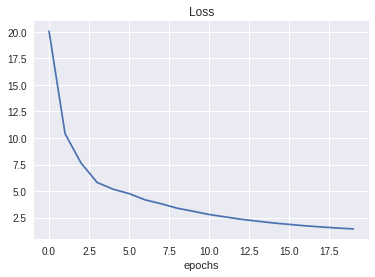

In [424]:
# Now, we train on the real dataset!
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights,  X_train, y_train_ohe, batch_size=32, num_epoch=20, learning_rate=0.1, plot_loss=True, lam=0.1)#, plot_per_epoch=False)
W1_learned_nn, W2_learned_nn, b1_learned_nn, b2_learned_nn = params_nn

In [432]:
y_pred_nn, prob = make_prediction_network(X_train, W1_learned_nn, b1_learned_nn, W2_learned_nn, b2_learned_nn)

In [433]:
print(y_pred_nn)

[2 2 1 2 2 0 1 2 1 2 0 1 1 0 2 1 2 0 2 1 2 1 0 0 2 2 1 2 0 1 2 2 0 2 0 1 0
 2 2 0 2 2 2 0 1 0 2 1 0 2 0 1 2 1 2 1 1 2 2 0 2 0 0 1 2 0 2 2 0 0 0 2 2 1
 1 1 1 0 0 0 1 2 2 0 0 0 2 0 1 0 1 0 2 1 2 0 2 0 1 1 0 2 2 2 0 2 1 2 2 1 2
 2 1 2 0 2 1 2 0 0]


In [434]:
accuracy_nn = accuracy_score(Y_train, y_pred_nn)
print('Accuracy NN:', accuracy_nn)

Accuracy NN: 0.9166666666666666


In [436]:
y_pred_nn, prob = make_prediction_network(X_test, W1_learned_nn, b1_learned_nn, W2_learned_nn, b2_learned_nn)

In [437]:
accuracy = accuracy_score(Y_test, y_pred_nn)
print('Accuracy:', accuracy)

Accuracy: 1.0


Yay!